# Load Dataset

In [16]:
import torch 
import torchvision   
import torchvision.datasets as datasets 
device = 'mps' if torch.cuda.is_available() else 'cpu'

# downloading mnist
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))   
])
mnist_trainset = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)
mnist_testset = datasets.FashionMNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

## printing lengths

print('length of the training set: {}'.format(len(mnist_trainset)))
print('length of the test set: {}'.format(len(mnist_testset)))

## rendering a few example from each label


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw

length of the training set: 60000
length of the test set: 10000


# Preprocessing Step

In [31]:
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import OneHotEncoder

partition_index = 200  

def one_hot(y):
  #For converting a numpy array of 0-9 into a one hot encoding of vectors of length 10 
  b = np.zeros((y.size, y.max() + 1))
  b[np.arange(y.size), y] = 1
  return b

print('processing labeld training x and y')
train_x = np.asarray([np.asarray(mnist_trainset[i][0]) for i in tqdm(range(partition_index))])
train_y = one_hot(np.asarray([np.asarray(mnist_trainset[i][1]) for i in tqdm(range(partition_index))]))

print('processing unlabled training data')
train_unlabled = np.asarray([np.asarray(mnist_trainset[i][0]) for i in tqdm(range(200,len(mnist_trainset)))])

print('processing labeld test x and y')
test_x = np.asarray([np.asarray(mnist_testset[i][0]) for i in tqdm(range(len(mnist_testset)))])
test_y = one_hot(np.asarray([np.asarray(mnist_testset[i][1]) for i in tqdm(range(len(mnist_testset)))]))

print('reformatting shape...')
#train_x = np.expand_dims(train_x, 1)
#train_unlabled = np.expand_dims(train_unlabled, 1)
#test_x = np.expand_dims(test_x, 1)

#converting data to pytorch type
torch_train_x = torch.tensor(train_x.astype(np.float32), requires_grad=True).to(device)
torch_train_y = torch.tensor(train_y.astype(np.float32)).to(device)
torch_test_x = torch.tensor(test_x.astype(np.float32), requires_grad=True).to(device)
torch_test_y = torch.tensor(test_y.astype(np.float32)).to(device)
torch_train_unlabled = torch.tensor(train_unlabled.astype(np.float32), requires_grad=True).to(device)
 

processing labeld training x and y


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4774.66it/s]


processing unlabled training data


100%|██████████████████████████████████████████████████████████████████████████| 59800/59800 [00:11<00:00, 5277.71it/s]


processing labeld test x and y


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5363.86it/s]


reformatting shape...


# Defining Model

In [32]:
import torch.nn.functional as F
import torch.nn as nn

class Backbone(nn.Module):
    def __init__(self):
        super(Backbone, self).__init__()
        self.conv1 = nn.Conv2d(1,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,16,3,padding=1)
        self.conv3 = nn.Conv2d(16,32,3,padding=1)

        if torch.cuda.is_available():
            self.cuda()

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = torch.flatten(x, 1)
        return x

#defining model head
class Head(nn.Module):
    def __init__(self, n_class=10):
        super(Head, self).__init__()
        self.fc1 = nn.Linear(32*3*3, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, n_class)

        if torch.cuda.is_available():
            self.cuda()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = Backbone() 
        self.head = Head()

        if torch.cuda.is_available():
            self.cuda()

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

model_baseline = Model()
print(model_baseline(torch_train_x[:1]).shape)
model_baseline

torch.Size([1, 10])


Model(
  (backbone): Backbone(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (head): Head(
    (fc1): Linear(in_features=288, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=10, bias=True)
  )
)

# Train without unlabeled data

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [41:25<00:00,  1.24s/it]


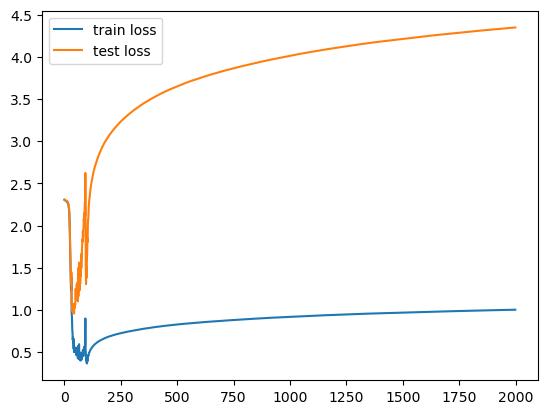

E:\Programs\Anaconda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 547x209475 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [33]:
def supervised_train(model):

    batch_size = 32
    lr = 0.01
    momentum = 0.9 # set to 0.9 or 0.95
    num_epochs = 2000 # a value more than 2000

    #defining a stocastic gradient descent optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    #defining loss function
    loss_fn = torch.nn.CrossEntropyLoss()

    train_hist = []
    test_hist = []
    test_accuracy = []

    for epoch in tqdm(range(num_epochs)):

        #iterating over all batches
        for i in range(int(len(train_x)/batch_size)-1):

            #Put the model in training mode, so that things like dropout work
            model.train(True) 

            # Zero gradients for the optimizer 
            optimizer.zero_grad()

            #extracting X and y values from the batch
            X = torch_train_x[i*batch_size: (i+1)*batch_size]
            y = torch_train_y[i*batch_size: (i+1)*batch_size]

            # Make predictions for this batch
            y_pred = model(X)

            #compute gradients with the loss function
            loss = loss_fn(y_pred, y)
            loss.backward()

            # Adjust learning weights
            optimizer.step()

        with torch.no_grad():

            #Disable things like dropout, if they exist
            model.train(False)

            #calculating epoch training and test loss
            train_loss = loss_fn(model(torch_train_x), torch_train_y).cpu().numpy()
            y_pred_test = model(torch_test_x)
            test_loss = loss_fn(y_pred_test, torch_test_y).cpu().numpy()

            train_hist.append(train_loss) # use train loss to plot
            test_hist.append(test_loss) # use test loss to plot

            #computing test accuracy
            matches = np.equal(np.argmax(y_pred_test.cpu().numpy(), axis=1), np.argmax(torch_test_y.cpu().numpy(), axis=1))
            test_accuracy.append(matches)

    import matplotlib.pyplot as plt
    plt.plot(train_hist, label = 'train loss')
    plt.plot(test_hist, label = 'test loss')
    plt.legend()
    plt.show()
    plt.plot(test_accuracy, label = 'test accuracy')
    plt.legend()
    plt.show()

    maxacc = max(test_accuracy)# maximum value of accuracy
    print('max accuracy: {}'.format(maxacc))
    
    return maxacc

supervised_maxacc = supervised_train(model_baseline)

# Data Augmentation

In [42]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

class Augment:

   def __init__(self):

       blur = T.GaussianBlur(kernel_size=(3, 3))

       self.train_transform = torch.nn.Sequential(
           T.RandomAffine(degrees=15, translate=(0.1,0.1)),
           T.RandomPerspective(distortion_scale=0.1, p=0.3),
           T.RandomPerspective(distortion_scale=0.4, p=0.3),
           T.RandomPerspective(0.2,0.5),
           T.RandomApply([blur],p=0.5),
           T.RandomApply([blur],p=0.7)
       )

   def __call__(self, x): 
       return self.train_transform(x), self.train_transform(x)

"""
Generating Test Augmentation
"""
a = Augment()
aug = a(torch_train_unlabled[0:100])

i=1
f, axarr = plt.subplots(2,2)
#positive pair
axarr[0,0].imshow(aug[0].cpu().detach().numpy()[i,0])
axarr[0,1].imshow(aug[1].cpu().detach().numpy()[i,0])
#another positive pair
axarr[1,0].imshow(aug[0].cpu().detach().numpy()[i+1,0])
axarr[1,1].imshow(aug[1].cpu().detach().numpy()[i+1,0])
plt.show()

RuntimeError: Calling torch.linalg.lstsq on a CPU tensor requires compiling PyTorch with LAPACK. Please use PyTorch built with LAPACK support.

# Defining Contrastive Loss

In [46]:
class ContrastiveLoss(nn.Module):
   def __init__(self, batch_size, temperature=0.5):

       super().__init__()
       self.batch_size = batch_size
       self.temperature = temperature
       self.mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float().to(device)

   def calc_similarity_batch(self, a, b):
       representations = torch.cat([a, b], dim=0)
       return F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

   def forward(self, proj_1, proj_2):
       batch_size = proj_1.shape[0]
       z_i = F.normalize(proj_1, p=2, dim=1)
       z_j = F.normalize(proj_2, p=2, dim=1)

       similarity_matrix = self.calc_similarity_batch(z_i, z_j)

       sim_ij = torch.diag(similarity_matrix, batch_size)
       sim_ji = torch.diag(similarity_matrix, -batch_size)

       positives = torch.cat([sim_ij, sim_ji], dim=0)

       nominator = torch.exp(positives / self.temperature)

       denominator = self.mask * torch.exp(similarity_matrix / self.temperature)

       all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
       loss = torch.sum(all_losses) / (2 * self.batch_size)
       return loss

loss = ContrastiveLoss(32) # use the above loss
fake_proj_0, fake_proj_1 = a(torch_train_x)
fake_proj_0 = fake_proj_0[:,0,:,0]
fake_proj_1 = fake_proj_1[:,0,:,0]
loss(fake_proj_0, fake_proj_1)

RuntimeError: Calling torch.linalg.lstsq on a CPU tensor requires compiling PyTorch with LAPACK. Please use PyTorch built with LAPACK support.

# Training on whole data

In [50]:
from torch.optim.lr_scheduler import ExponentialLR

model = Model().to(device)
model.train()

#defining key hyperparameters
batch_size = 512
epoch_size = len(torch_train_unlabled) // batch_size
num_epochs = 50# more than 50
patience = 5
cutoff_ratio = 0.001

#defining key learning functions
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_examples = len(torch_train_unlabled)
lossfn = ContrastiveLoss
augmentfn = Augment()

#for book keeping
loss_hist = []
improvement_hist = []
schedule_hist = []

#for exponentially decreasing learning rate
scheduler = ExponentialLR(optimizer, gamma = 0.95)

#for early stopping
patience_count = 0

#Training Loop
avg_loss = 1e10
for i in range(num_epochs):

    print('epoch {}/{}'.format(i,num_epochs))

    total_loss = 0
    loss_change = 0

    for j in tqdm(range(epoch_size)):

        #getting random batch
        X = torch_train_unlabled[j*batch_size: (j+1)*batch_size]

        #creating pairs of augmented batches
        X_aug_i, X_aug_j = augmentfn(X)

        #ensuring gradients are zero
        optimizer.zero_grad()

        #passing through the model
        z_i = model(X_aug_i)
        z_j = model(X_aug_j)

        #calculating loss on the model embeddings, and computing gradients
        loss = lossfn(z_i, z_j)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        if True:
            z_i = model(X_aug_i)
            z_j = model(X_aug_j)

            #calculating new loss value
            new_loss = lossfn(z_i, z_j)

            loss_change += new_loss.cpu().detach().numpy() - loss.cpu().detach().numpy()

        total_loss += loss.item()

        #step learning rate scheduler
        schedule_hist.append(scheduler.get_last_lr())

    #########################
    # update scheduler here #
    #########################
    
    #calculating percentage loss reduction
    new_avg_loss = total_loss/epoch_size
    per_loss_reduction = (avg_loss-new_avg_loss)/avg_loss
    print('Percentage Loss Reduction: {}'.format(per_loss_reduction))

    #deciding to stop if loss is not decreasing fast enough
    if per_loss_reduction < cutoff_ratio:
        patience_count+=1
        print('patience counter: {}'.format(patience_count))
        if patience_count > patience:
            break
    else:
        patience_count = 0

    #setting new loss as previous loss
    avg_loss = new_avg_loss

    #book keeping
    avg_improvement = loss_change/epoch_size
    loss_hist.append(avg_loss)
    improvement_hist.append(avg_improvement)
    print('Average Loss: {}'.format(avg_loss))
    print('Average Loss change (if calculated): {}'.format(avg_improvement))

epoch 0/50


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]


RuntimeError: Calling torch.linalg.lstsq on a CPU tensor requires compiling PyTorch with LAPACK. Please use PyTorch built with LAPACK support.

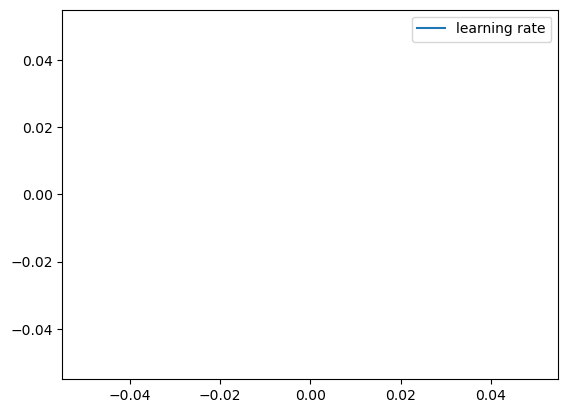

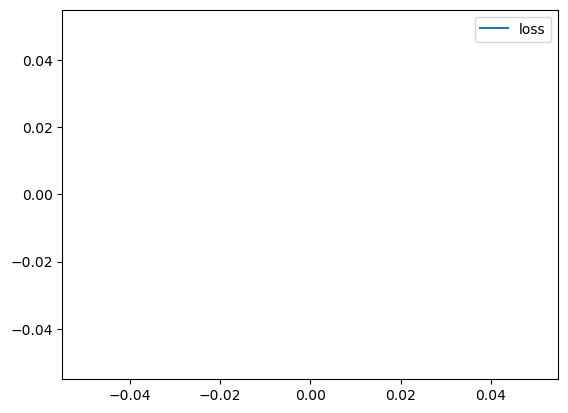

In [51]:
plt.plot(schedule_hist, label='learning rate')
plt.legend()
plt.show()
plt.plot(loss_hist, label = 'loss')
plt.legend()
plt.show()